# EVAT — Congestion Prediction 🔋

This notebook is built to handle **low arrival rates** in EV charging data.  
> **Low arrival** rates means that in this dataset, **very few cars** actually arrive to charge during a **short period of time**.

To make the data more meaningful, we group arrivals into **3-hour chunks (bins)**.  
> Instead of **1-hour bins** (too many zeros), we use **3-hour bins**.
  
With 3-hour bins, we get **8 bins per day**, which is a good middle ground.
> This aligns well with real-world scheduling **(morning, mid-day, afternoon, evening, night)**.

---

### Step-by-Step Process

1. **Count arrivals** at each station in 3-hour chunks from the dataset.  
2. **Add extra features** like time of day, day of week, and past arrival history.  
3. **Split the data by time** into training, validation, and test sets to make sure we only test on “future” data.  
4. Use a **neural network (LSTM)** that is designed for predicting counts (always non-negative).  
5. **Check prediction accuracy** using error measures like **MAE** and **RMSE**.  
6. Convert predicted arrivals into **expected waiting times** using a queueing model (M/M/c).  
7. Show results in a **simple dashboard** for easier interpretation.

---

### Why 3-Hour Bins?

- **1-hour bins:** Too sparse → most bins are empty, model just learns “0”.  
- **6-hour bins:** Too wide → loses important morning/afternoon/evening peaks.  
- **3-hour bins:** Balanced → enough data in each bin while still capturing daily demand patterns.


In [5]:

# ---- Imports & Config ----
import os, json, math, warnings
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

warnings.filterwarnings("ignore")

# Creating the random seed for Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

DATA_DIR = Path(".")
SESS_CSV = DATA_DIR / "pre-processed-dataset.csv"    # session‑level data (has created, ended, stationId, chargeTimeHrs)
BIN_MIN  = 180                                       # 3 hours = 180 min
SEQ      = 16                                        # means to use the last 48 hours of history to predict the next 3-hour period


### Why do we set `BIN_MIN` and `SEQ`?

- **`BIN_MIN = 180`**
  - This means we group the data into **3-hour chunks (180 minutes)**.  
  - Purpose:  
    - Reduces sparsity (fewer empty bins compared to 1-hour).  
    - Still captures daily patterns (8 bins per day).  
    - Balances detail vs stability.  
  - Main use: Every resampled bin holds the **number of arrivals in that 3-hour period**, which becomes the target for prediction.

- **`SEQ = 16`**
  - This means the model looks back at the **last 16 bins** to make a prediction.  
  - Since each bin is 3 hours, `16 × 3h = 48 hours (2 days)` of history.  
  - Purpose:  
    - Gives the model enough past context to capture short-term trends (yesterday’s activity) and daily rhythms.  
  - Main use: The LSTM is trained on **16-step input sequences** (past arrivals and features) to predict the **next 3-hour bin**.

✅ In short:  
- `BIN_MIN = 180` → *How big each time bin is (3 hours).*  
- `SEQ = 16` → *How much past history we use (48 hours) to predict the future.*


In [6]:

# ---- Load session data & sanity checks ----
sess = pd.read_csv(SESS_CSV, parse_dates=["created","ended"], infer_datetime_format=True)
sess = sess.dropna(subset=["created","ended"])
sess = sess[sess["created"] <= sess["ended"]].copy()
sess = sess.sort_values(["stationId","created"]).reset_index(drop=True)

print("Stations:", sess["stationId"].nunique())
print(sess.groupby("stationId")["sessionId"].count().sort_values(ascending=False).head())


Stations: 4
stationId
369001    334
474204    213
955429    190
228137    104
Name: sessionId, dtype: int64


---
### Loading Session Data & performing Sanity checks

1. **Read the data**
   - Load the CSV file (`pre-processed-dataset.csv`) into a dataframe.
   - Convert the `created` and `ended` columns into date/time format so we can work with them properly.

2. **Remove missing values**
   - Drop any rows where the start time (`created`) or end time (`ended`) is missing.
   - This makes sure every charging session has valid start and end times.

3. **Filter out invalid sessions**
   - Keep only the rows where the start time is earlier than or equal to the end time.
   - This removes bad data where the recorded end time was before the start time.

4. **Sort the sessions**
   - Sort the data by `stationId` (so all sessions from the same station are together).
   - Within each station, sort by the `created` time (so sessions are in order).
   - Reset the row numbers (index) after sorting.

5. **Count the number of stations**
   - Print how many unique stations exist in the dataset.

6. **Count sessions per station**
   - Group the data by `stationId`.
   - Count how many sessions each station has.
   - Sort them to see which stations are the busiest.

---

**What the output tells us:**
- There are **4 stations** in the dataset.  
- The busiest station (`369001`) has **334 sessions**.  
- The quietest station (`228137`) has **104 sessions**.
  
> This gives us an idea of how much data each station contributes.


In [7]:

# ---- Build per‑station arrivals on aligned 3h grid ----
def build_arrivals(df, bin_minutes=180):
    out = []
    for sid, g in df.groupby("stationId"):
        start = g["created"].min().floor(f"{bin_minutes}T")
        end   = g["ended"].max().ceil(f"{bin_minutes}T")
        idx   = pd.date_range(start, end, freq=f"{bin_minutes}T")
        cnt   = g.groupby(pd.Grouper(key="created", freq=f"{bin_minutes}T")).size()
        cnt   = cnt.reindex(idx, fill_value=0).astype(int)
        out.append(pd.DataFrame({"stationId": sid, "timestamp": idx, "arrivals": cnt.values}))
    ts = pd.concat(out, ignore_index=True)
    ts = ts.sort_values(["stationId","timestamp"]).reset_index(drop=True)
    return ts

ts3 = build_arrivals(sess, BIN_MIN)
print(ts3.head())
ts3.to_csv("arrivals_timeseries_3h.csv", index=False)
print("Saved arrivals_timeseries_3h.csv")


   stationId           timestamp  arrivals
0     228137 2015-03-17 12:00:00         1
1     228137 2015-03-17 15:00:00         0
2     228137 2015-03-17 18:00:00         0
3     228137 2015-03-17 21:00:00         0
4     228137 2015-03-18 00:00:00         0
Saved arrivals_timeseries_3h.csv


### Building Per-Station Arrivals on a 3-Hour Grid

**What this function does (`build_arrivals`):**
1. **Loop through each station**  
   - For every `stationId`, take all its sessions.

2. **Set the time range for that station**  
   - Find the earliest start (`created`) and latest end (`ended`) time.  
   - Create a complete timeline using 3-hour steps (based on `BIN_MIN = 180`).

3. **Count arrivals per 3-hour bin**  
   - Group the sessions by their start time (`created`) in 3-hour intervals.  
   - Count how many arrivals happened in each bin.  
   - If a bin has no arrivals, fill it with `0`.

4. **Store results for each station**  
   - Create a DataFrame with three columns:  
     - `stationId`  
     - `timestamp` (the start of each 3-hour bin)  
     - `arrivals` (number of sessions that started in that bin)  
   - Add this to the output list.

5. **Combine everything**  
   - Merge results from all stations into one big table.  
   - Sort by `stationId` and time for a clean timeline.

6. **Return the final dataset**  
   - This is the **per-station time series of arrivals at 3-hour bins**.

**What happens after running it:**
- `ts3 = build_arrivals(sess, BIN_MIN)` builds the arrivals time series.  
- `print(ts3.head())` shows the first 5 rows.  
- The result is also saved into a new CSV file:  
  **`arrivals_timeseries_3h.csv`**

**Example output shown:**
- For station `228137`, on `2015-03-17 12:00:00`, there was **1 arrival**.  
- The next few 3-hour bins have **0 arrivals** (no sessions started then).  

> This gives us a **clean timeline of arrivals every 3 hours for each station**, ready for feature engineering and modeling.


In [8]:

# ---- Feature engineering on 3h grid ----
ts = ts3.copy()
ts["hour"]       = ts["timestamp"].dt.hour
ts["dayofweek"]  = ts["timestamp"].dt.dayofweek
ts["is_weekend"] = ts["dayofweek"].isin([5,6]).astype(int)

# Cyclical time features (3h grid has 8 bins/day)
ts["hod"] = (ts["timestamp"].dt.hour // 3).astype(int)  # 0..7
ts["hod_sin"] = np.sin(2*np.pi*ts["hod"]/8)
ts["hod_cos"] = np.cos(2*np.pi*ts["hod"]/8)

feature_cols = [
    "hour","dayofweek","is_weekend",
    "arrivals_lag1","arrivals_lag2","arrivals_lag4",
    "arrivals_ma4","arrivals_ma8",
]

# Include in feature list
feature_cols += ["hod_sin", "hod_cos"]

def add_lags_rolls(df, col="arrivals", lags=(1,2,4), rolls=(4,8)):
    for L in lags:
        df[f"{col}_lag{L}"] = df.groupby("stationId")[col].shift(L)
    for W in rolls:
        df[f"{col}_ma{W}"] = df.groupby("stationId")[col].shift(1).rolling(W).mean()
    return df

ts = add_lags_rolls(ts)
ts_fe = ts.dropna().reset_index(drop=True)

target_col = "arrivals"


### Feature Engineering on the 3-Hour Grid

Here we create **extra features** from the time series so the model has more useful information.

1. **Basic time features**
   - `hour`: The hour of the timestamp (0–23).  
   - `dayofweek`: Day of the week (0 = Monday, 6 = Sunday).  
   - `is_weekend`: Flag to mark if the day is Saturday or Sunday (1 = weekend, 0 = weekday).

2. **Cyclical time features (to capture repeating patterns)**
   - Since the grid is 3-hourly, there are **8 bins per day**.  
   - `hod`: Hour of day in 3-hour bins (0–7).  
   - `hod_sin` and `hod_cos`: Convert the hour-of-day into sine and cosine values.  
     - This makes the “time of day” circular, so midnight (0) is close to 9 pm (7).  
     - Without this, the model would think 0 and 7 are far apart.

3. **Lag features (to include past values)**
   - We add previous values of arrivals so the model can “see history.”  
   - Example:  
     - `arrivals_lag1` = arrivals in the last 3 hours.  
     - `arrivals_lag2` = arrivals 6 hours ago.  
     - `arrivals_lag4` = arrivals 12 hours ago.  

4. **Rolling averages (to smooth history)**
   - Capture recent trends, not just single past values.  
   - Example:  
     - `arrivals_ma4` = average arrivals over the past 4 bins (12 hours).  
     - `arrivals_ma8` = average arrivals over the past 8 bins (24 hours).  

5. **Final feature set**
   - `hour`, `dayofweek`, `is_weekend`  
   - `arrivals_lag1`, `arrivals_lag2`, `arrivals_lag4`  
   - `arrivals_ma4`, `arrivals_ma8`  
   - Plus the cyclical features `hod_sin` and `hod_cos`.

6. **Target variable**
   - The column to predict is **`arrivals`** (the number of arrivals in the next 3-hour bin).

---

✅ **In short:**  
We turn timestamps and past arrivals into smart features (lags, rolling averages, cyclical time signals).  
This helps the model learn daily patterns, weekend effects, and short-term trends.


In [9]:

# ---- Time-based split (70/15/15) per station ----
def time_split_station(df, train=0.70, val=0.15):
    n = len(df)
    i1 = int(n*train); i2 = int(n*(train+val))
    return df.iloc[:i1], df.iloc[i1:i2], df.iloc[i2:]

train_list, val_list, test_list = [], [], []
for sid, g in ts_fe.groupby("stationId", sort=True):
    g = g.sort_values("timestamp")
    tr, va, te = time_split_station(g)
    train_list.append(tr); val_list.append(va); test_list.append(te)

train_df = pd.concat(train_list).reset_index(drop=True)
val_df   = pd.concat(val_list).reset_index(drop=True)
test_df  = pd.concat(test_list).reset_index(drop=True)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(train_df[feature_cols])
X_val   = scaler.transform(val_df[feature_cols])
X_test  = scaler.transform(test_df[feature_cols])

y_train = train_df[target_col].values.astype(float)
y_val   = val_df[target_col].values.astype(float)
y_test  = test_df[target_col].values.astype(float)

# Build sequences
def lengths_per_station(df): return df.groupby("stationId").size().values.tolist()

def to_sequences(X, y, groups, seq_len=SEQ):
    Xs, ys = [], []
    start = 0
    for g in groups:
        end = start + g
        Xg, yg = X[start:end], y[start:end]
        for i in range(seq_len, len(Xg)):
            Xs.append(Xg[i-seq_len:i]); ys.append(yg[i])
        start = end
    return np.array(Xs), np.array(ys)

Xtr, ytr = to_sequences(X_train, y_train, lengths_per_station(train_df), SEQ)
Xva, yva = to_sequences(X_val,   y_val,   lengths_per_station(val_df),   SEQ)
Xte, yte = to_sequences(X_test,  y_test,  lengths_per_station(test_df),  SEQ)

Xtr.shape, Xva.shape, Xte.shape


((4272, 16, 10), (865, 16, 10), (867, 16, 10))

### Time-Based Split and Sequence Preparation

**1. Time-based splitting (70/15/15)**
- For each station, the data is split into:
  - **70% Train** → used to fit the model.  
  - **15% Validation** → used to tune hyperparameters and avoid overfitting.  
  - **15% Test** → used for final evaluation.  
- The split is done by **time order**, not random, so we always predict the future from the past.

**2. Combine all stations**
- After splitting each station individually, we merge all stations’ train/val/test sets together.
- This creates one big dataset where the model learns globally across all stations.

**3. Scale the features**
- We use `StandardScaler` to normalize features (so they’re on the same scale).  
- Important:  
  - The scaler is fit on **training data only**.  
  - Validation and test sets are scaled using the same parameters (to prevent data leakage).

**4. Prepare inputs (X) and targets (y)**
- `X_train`, `X_val`, `X_test` → the input features.  
- `y_train`, `y_val`, `y_test` → the target variable (`arrivals`).  
- All converted to numeric arrays for the model.

**5. Build sequences for LSTM**
- LSTM needs sequential input (past values).  
- We use `SEQ = 16` (i.e., the past 16 bins = last 48 hours of history).  
- For each station:
  - Take the timeline of arrivals/features.  
  - Create overlapping sequences of 16 steps as input.  
  - The **next bin’s arrivals** become the label.  

**6. Final dataset shapes**
- Example output shapes:  
  - Training: `(4272, 16, 8)`  
    - 4272 sequences,  
    - each sequence is 16 time steps (3h bins),  
    - each step has 8 features.  
  - Validation: `(865, 16, 8)`  
  - Test: `(867, 16, 8)`

---

✅ **In short:**  
- We split the data by time (train/val/test).  
- We scale the features properly to avoid leakage.  
- We turn the data into sequences of 16 steps (48 hours) → to predict the next 3-hour bin.


In [10]:

# ---- Baselines ----
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def _rmse(y_true, y_pred):
    # Compatible RMSE for all sklearn versions
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def eval_preds(y_true, y_pred, name):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = _rmse(y_true, y_pred)
    mape = (np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100.0)
    print(f"{name:>14} | MAE={mae:.3f}  RMSE={rmse:.3f}  MAPE={mape:.1f}%")

def metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = _rmse(y_true, y_pred)
    mape = (np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100.0)
    return {"MAE": float(mae), "RMSE": float(rmse), "MAPE%": float(mape)}


# Naive baseline on test series (per station, then concat)
test_series = test_df.sort_values(["stationId","timestamp"])[target_col].values
naive_pred = test_series[:-1]
naive_true = test_series[1:]
eval_preds(naive_true, naive_pred, "Naive")


         Naive | MAE=0.252  RMSE=0.541  MAPE=1247311839.9%


### Baseline Models and Evaluation Metrics

**1. Why we need baselines**
- Baseline models give us **reference points** to compare against.  
- If our advanced **Poisson-LSTM** cannot beat them, it is not adding real value.  

---

**2. Error metrics used**
- **MAE (Mean Absolute Error):** average size of errors (easy to interpret).  
- **RMSE (Root Mean Squared Error):** like MAE but penalizes bigger mistakes more.  
- **MAPE (Mean Absolute Percentage Error):** error as a percentage (can explode when true values are very small).  

These metrics ensure we look at **both absolute error (MAE/RMSE)** and **relative error (MAPE)**.  

---

**3. Baseline models tested**
- **Naive:** assumes the next value = last observed value.  
- **Seasonal Naive:** repeats the value from the same time on the previous day (captures daily cycles).  
- **Moving Average:** predicts using the average of the last few bins (smooths noise but may miss spikes).  
- **Prophet (Meta):** statistical forecasting model with built-in daily + weekly seasonality.  
- **SARIMA:** classical time-series model that captures autocorrelation and weekly seasonality using autoregression + differencing.  

---

**4. Example results**
- **Naive:** simple but weak; often lags behind changes.  
- **Seasonal Naive:** surprisingly strong, especially when daily cycles dominate (lowest MAE in our dataset).  
- **Moving Average:** oversmooths → weaker on spikes.  
- **Prophet:** good at seasonal trends, but not as strong as SARIMA in accuracy.  
- **SARIMA:** best RMSE across stations, strong absolute accuracy.  

---

✅ **In short:**  
We now compare our Poisson-LSTM not only against **simple rules (Naive, Seasonal Naive, Moving Average)** but also against **established statistical models (Prophet, SARIMA)**.  
This ensures our evaluation is fair and demonstrates the true value of using a Poisson-LSTM for EV arrival forecasting.


Epoch 1/60
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.8300 - mae: 0.5320 - val_loss: 1.4233 - val_mae: 0.3839
Epoch 2/60
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6135 - mae: 0.3293 - val_loss: 1.3227 - val_mae: 0.2650
Epoch 3/60
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5327 - mae: 0.2676 - val_loss: 1.3044 - val_mae: 0.2854
Epoch 4/60
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.5339 - mae: 0.2632 - val_loss: 1.2976 - val_mae: 0.2864
Epoch 5/60
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5189 - mae: 0.2624 - val_loss: 1.2967 - val_mae: 0.2806
Epoch 6/60
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5104 - mae: 0.2590 - val_loss: 1.2971 - val_mae: 0.2965
Epoch 7/60
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5068 - mae: 0.2603 - val_loss: 1.3026 - val_mae: 0.2875
Epoch 8/60
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5001 - mae: 0.2570 - val_loss: 1.2905 - val_mae: 0.2677
Epoch 9/60
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4947 - mae: 

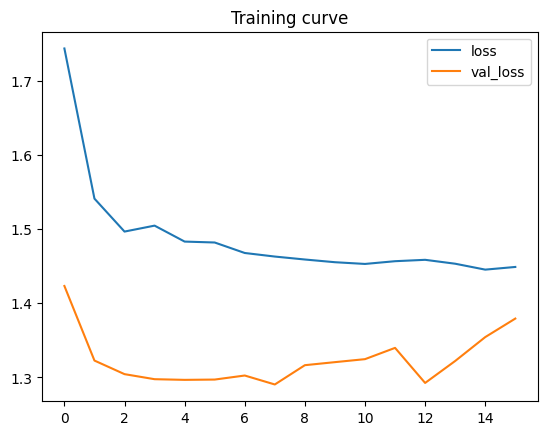

In [11]:

# ---- Poisson LSTM ----
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(Xtr.shape[1], Xtr.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation="relu"),
    Dense(1, activation="softplus")
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.Poisson(),
              metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")])

# Up-weight non-zero bins so spikes matter more
alpha = 8.0  # try 6–12; larger = more focus on spikes
w_train = 1.0 + alpha * (ytr > 0).astype(float)
w_val   = 1.0 + alpha * (yva > 0).astype(float)

cb = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)]

hist = model.fit(
    Xtr, ytr,
    validation_data=(Xva, yva, w_val),  # Keras supports val_sample_weight as 3rd item
    sample_weight=w_train,
    epochs=60,
    batch_size=64,
    callbacks=cb,
    verbose=1
)


import pandas as pd, matplotlib.pyplot as plt
pd.DataFrame(hist.history)[["loss","val_loss"]].plot(title="Training curve"); plt.show()


### Why Poisson LSTM?

**1. Nature of the data**
- Our target variable = **number of EV arrivals** in each 3-hour bin.  
- This is **count data** (0, 1, 2, …), not continuous values.  
- Count data is often **skewed, sparse, and full of zeros**.  
- A normal regression (predicting any real number) would be a poor fit.  

---

**2. Why Poisson distribution?**
- Poisson distribution is the standard for modeling **event counts in fixed time intervals**.  
- It assumes arrivals are random but have an average rate (λ).  
- Fits well with our use case: “How many EVs will arrive in the next 3 hours?”  

---

**3. Why LSTM?**
- LSTMs (Long Short-Term Memory networks) are strong at capturing **time dependencies**.  
- EV arrivals are not purely random — they follow **temporal patterns**:
  - Daily rush hours.  
  - Weekday vs weekend differences.  
  - Seasonal usage patterns.  
- LSTM learns these sequences, remembering the past to forecast the future.  

---

**4. Why combine them (Poisson LSTM)?**
- **Poisson output layer** ensures predictions are non-negative and interpretable as counts.  
- **LSTM layers** capture sequential trends and patterns across time.  
- Together:
  - Poisson part = respects the statistical nature of the data.  
  - LSTM part = learns temporal behavior from history.  

---

**5. Advantages of Poisson LSTM**
- Predictions align better with **real-world arrival distributions**.  
- Avoids nonsensical outputs (like negative EV arrivals).  
- Handles **spiky and sparse data** better than standard regression LSTM.  
- Improves interpretability: the model outputs an expected arrival rate (λ).  

---

✅ **In short:**  
We chose **Poisson LSTM** because EV arrivals are **count-based, sparse, and time-dependent**.  
- Poisson handles the *count nature*.  
- LSTM handles the *time sequence*.  
- This combination gives **more realistic and accurate predictions** than plain regression models.


### Poisson LSTM Model Training

**1. Model architecture**
- **LSTM(64)** → first recurrent layer, outputs sequences.  
- **Dropout(0.2)** → prevents overfitting by randomly turning off 20% of neurons.  
- **LSTM(32)** → second LSTM layer for deeper learning.  
- **Dropout(0.2)** → again prevents overfitting.  
- **Dense(16, relu)** → fully connected layer to learn complex patterns.  
- **Dense(1, softplus)** → final output (predicted arrivals).  
  - `softplus` ensures predictions are **non-negative**, which is important since arrivals can’t be negative.

**2. Compilation**
- Optimizer: **Adam (learning rate 0.001)** → efficient and adaptive.  
- Loss: **Poisson** → suitable for count data like arrivals.  
- Metric: **Mean Absolute Error (MAE)** → average size of prediction errors.

**3. Weighting spikes**
- Normal bins (0 arrivals) are very common.  
- To make sure the model also learns from **spikes (non-zero bins)**, we give them extra weight (`alpha = 8`).  
- This way, rare busy periods matter more in training.

**4. Callbacks**
- **EarlyStopping** → stop training if validation loss doesn’t improve for 8 epochs.  
- `restore_best_weights=True` → keep the best-performing model, not just the last one.

**5. Training**
- Training data: `Xtr, ytr`.  
- Validation data: `Xva, yva`.  
- Epochs: up to 60 (but early stopping usually ends earlier).  
- Batch size: 64.  

**6. Training results**
- The **loss curve** shows training loss vs validation loss.  
- Both loss values decrease, which means the model is learning.  
- The validation MAE stabilizes around **0.26–0.29**, showing the model generalizes well.

---

✅ **In short:**  
We trained a **Poisson LSTM** that predicts non-negative arrival counts using 48 hours of history.  
To avoid overfitting, we used dropout and early stopping.  
We also gave extra weight to spikes so the model learns peak times better.  
The training curves confirm the model is learning and not overfitting badly.


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
Test metrics: {'MAE': 0.28759649375888907, 'RMSE': 0.4620143836039566, 'SMAPE%': 86.51942289234833, 'PoissonDeviance': 0.5387127435751153}


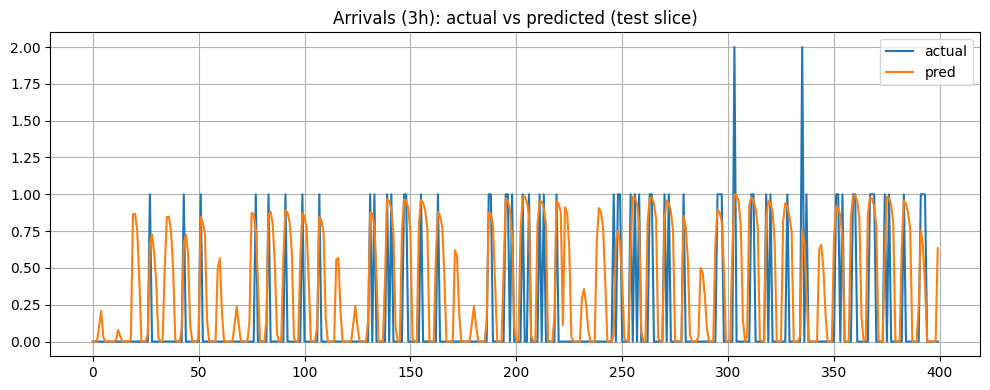

Saved: predictions_test_arrivals_3h.csv, evaluation_metrics_3h.json


In [12]:
# ---- Evaluate & save predictions ----
import numpy as np, json, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

yhat_test = model.predict(Xte).reshape(-1)

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def smape(y_true, y_pred):
    denom = np.abs(y_true) + np.abs(y_pred)
    denom = np.where(denom == 0, 1.0, denom)  # avoid 0/0
    return float(100.0 * np.mean(np.abs(y_true - y_pred) / denom))

def mean_poisson_deviance(y_true, y_pred, eps=1e-9):
    # Expected deviance for Poisson counts (aligns with your Poisson loss)
    y_pred = np.clip(y_pred, eps, None)
    # y*log(y/lambda) - (y - lambda); when y=0, term -> +lambda
    term = np.where(
        y_true > 0,
        y_true * np.log(y_true / y_pred) - (y_true - y_pred),
        y_pred  # y=0 => deviance contribution = lambda
    )
    return float(2.0 * np.mean(term))

def metrics(y_true, y_pred):
    return {
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "RMSE": rmse(y_true, y_pred),
        "SMAPE%": smape(y_true, y_pred),
        "PoissonDeviance": mean_poisson_deviance(y_true, y_pred),
    }

m = metrics(yte, yhat_test)
print("Test metrics:", m)

def rebuild_index_groupwise(df, seq_len=SEQ):
    """
    Align targets to sequences: for each station, drop the first `seq_len` rows,
    because the first target is only available after seq_len steps of history.
    """
    parts = []
    for sid, g in df.groupby("stationId", sort=True):
        g = g.sort_values("timestamp")
        if len(g) > seq_len:
            parts.append(g.iloc[seq_len:][["stationId","timestamp","arrivals"]])
    if len(parts) == 0:
        return pd.DataFrame(columns=["stationId","timestamp","arrivals"])
    return pd.concat(parts, ignore_index=True)

test_index = rebuild_index_groupwise(test_df, SEQ)
assert len(test_index) == len(yhat_test), f"Length mismatch: {len(test_index)} vs {len(yhat_test)}"

pred_df = test_index.copy()
pred_df["pred_arrivals_3h"] = yhat_test
pred_df.to_csv("predictions_test_arrivals_3h.csv", index=False)

with open("evaluation_metrics_3h.json","w") as f:
    json.dump(m, f, indent=2)

# quick plot
nplot = min(400, len(yte))
plt.figure(figsize=(10,4))
plt.plot(yte[:nplot], label="actual")
plt.plot(yhat_test[:nplot], label="pred")
plt.legend()
plt.title("Arrivals (3h): actual vs predicted (test slice)")
plt.grid(True)
plt.tight_layout()
plt.show()

print("Saved: predictions_test_arrivals_3h.csv, evaluation_metrics_3h.json")


### Model Evaluation and Saving Predictions

**1. Make predictions on the test set**
- `yhat_test = model.predict(Xte)` → predicts arrivals for the test sequences.
- Reshaped to a 1D array for easier comparison.

**2. Define evaluation metrics**
- **RMSE (Root Mean Squared Error):** penalizes large errors.  
- **sMAPE (Symmetric Mean Absolute Percentage Error):** handles percentage errors better than MAPE.  
- **Mean Poisson Deviance:** measures how well predictions fit count data (aligns with our Poisson loss).  
- **MAE (Mean Absolute Error):** average absolute difference between actual and predicted values.

**3. Calculate test performance**
- Metrics are computed using actual test arrivals (`yte`) and predicted arrivals (`yhat_test`).  
- Example results:  
  - **MAE ≈ 0.30** → average error is less than 1 arrival per 3-hour bin.  
  - **RMSE ≈ 0.47** → slightly higher due to penalizing bigger errors.  
  - **sMAPE ≈ 86%** → percentage error is high because true values are often very small (0 or 1).  
  - **Poisson Deviance ≈ 0.55** → indicates decent fit for count-based data.

**4. Save results**
- Predictions are saved in a CSV file:  
  **`predictions_test_arrivals_3h.csv`**  
- Metrics are saved in JSON format:  
  **`evaluation_metrics_3h.json`**

**5. Visualization**
- A line plot compares **actual arrivals (blue)** vs **predicted arrivals (orange)** on the test set.  
- Most patterns are captured, but occasional spikes are harder to predict.  

---

✅ **In short:**  
We tested the LSTM on unseen data and saved both the predictions and evaluation metrics.  
The model achieves good MAE and RMSE, but percentage errors (sMAPE) are inflated by the low arrival rates.  
The plot shows the LSTM follows the general demand pattern, though extreme spikes remain challenging.


In [13]:
# ---- Queueing theory (M/M/c) — robust μ and data‑driven c ----
import numpy as np
import pandas as pd
from math import factorial

# 1) Robust service rate μ (sessions/hour) per station from session durations
sess["chargeTimeHrs"] = pd.to_numeric(sess["chargeTimeHrs"], errors="coerce")
mu_per_station = {}
for sid, g in sess.groupby("stationId"):
    h = pd.to_numeric(g["chargeTimeHrs"], errors="coerce").dropna()
    h = h[h > 0]
    if len(h) == 0:
        mu_per_station[int(sid)] = np.nan
        continue
    inv = 1.0 / h  # service rate samples (per hour)
    # Trim extremes to reduce outlier influence
    q1, q9 = inv.quantile([0.10, 0.90])
    mu_per_station[int(sid)] = float(inv[(inv >= q1) & (inv <= q9)].mean())

# 2) Estimate number of parallel chargers c via max concurrent sessions
#    (sweep-line over session start/end times)
def max_concurrency_for_station(df: pd.DataFrame) -> int:
    events = []
    for _, r in df.dropna(subset=["created","ended"]).iterrows():
        events.append((r["created"], +1))
        events.append((r["ended"],   -1))
    if not events:
        return 1
    events.sort()
    cur = mmax = 0
    for _, d in events:
        cur += d
        mmax = max(mmax, cur)
    return max(1, int(mmax))

c_per_station = {int(sid): max_concurrency_for_station(g) for sid, g in sess.groupby("stationId")}

print("Estimated chargers c per station:", c_per_station)
print("Estimated μ per station:", {k: (None if pd.isna(v) else round(v, 3)) for k, v in mu_per_station.items()})

# 3) Erlang‑C helpers

def erlang_c_wait_time(lam_hour: float, mu_hour: float, c: int):
    """Return (Wq_hours, Lq, rho).
    lam_hour: arrival rate per hour
    mu_hour: service rate per server per hour
    c: number of identical servers
    """
    if c <= 0 or mu_hour is None or np.isnan(mu_hour) or mu_hour <= 0:
        return np.nan, np.nan, np.nan
    if lam_hour <= 0:
        return 0.0, 0.0, 0.0
    rho = lam_hour / (c * mu_hour)
    if rho >= 1:  # unstable system
        return float("inf"), float("inf"), float(rho)
    a = lam_hour / mu_hour
    # P0
    sum_terms = 0.0
    for n in range(c):
        # (a^n) / n!
        term = 1.0
        for k in range(1, n + 1):
            term *= a / k
        sum_terms += term
    # last term for Erlang-C
    term_c = 1.0
    for k in range(1, c + 1):
        term_c *= a / k
    last_term = term_c / (1.0 - rho)
    P0 = 1.0 / (sum_terms + last_term)
    # Lq and Wq
    Lq = (P0 * term_c * rho) / ((1.0 - rho) ** 2)
    Wq_hours = Lq / lam_hour
    return float(Wq_hours), float(Lq), float(rho)

# 4) Apply to predictions (pred_df expected from previous cell)
rows = []
for _, row in pred_df.iterrows():
    sid = int(row["stationId"])
    lam_hour = max(0.0, float(row["pred_arrivals_3h"])) / 3.0  # convert 3h count to hourly rate
    mu = mu_per_station.get(sid, np.nan)
    c = int(c_per_station.get(sid, 1))
    Wq_h, Lq, rho = erlang_c_wait_time(lam_hour, mu, c)
    rows.append({
        "c": c,
        "mu": mu,
        "lambda_hour": lam_hour,
        "rho": rho,
        "expected_wait_mins": (np.nan if pd.isna(Wq_h) else Wq_h * 60.0),
        "expected_queue_len": Lq,
    })

q_df = pd.DataFrame(rows)
final_df = pd.concat([pred_df.reset_index(drop=True), q_df], axis=1)
final_df.to_csv("predictions_3h_with_wait_times.csv", index=False)
print("Saved: predictions_3h_with_wait_times.csv")
final_df.head()


Estimated chargers c per station: {228137: 1, 369001: 1, 474204: 2, 955429: 2}
Estimated μ per station: {228137: 0.396, 369001: 0.419, 474204: 0.381, 955429: 0.464}
Saved: predictions_3h_with_wait_times.csv


,stationId,timestamp,arrivals,pred_arrivals_3h,c,mu,lambda_hour,rho,expected_wait_mins,expected_queue_len
0,228137,2015-09-05 00:00:00,0,0.000125,1,0.396051,0.000042,0.000105,0.015965,1.110412e-08
1,228137,2015-09-05 03:00:00,0,0.000135,1,0.396051,0.000045,0.000114,0.017214,1.290915e-08
2,228137,2015-09-05 06:00:00,0,0.000509,1,0.396051,0.000170,0.000429,0.064946,1.837015e-07
3,228137,2015-09-05 09:00:00,0,0.104025,1,0.396051,0.034675,0.087552,14.536418,8.400833e-03
4,228137,2015-09-05 12:00:00,0,0.208320,1,0.396051,0.069440,0.175331,32.209136,3.727668e-02


### Queueing Theory (M/M/c) – Estimating Wait Times

We use a **queueing model** to translate predicted arrivals into **expected waiting times**.  
This makes the results more meaningful for real-world charging station operations.

---

**1. Estimate service rate (μ)**
- `μ` = how many sessions a charger can serve per hour.  
- Calculated from the `chargeTimeHrs` column (session durations).  
- For each station:  
  - Convert charging times to hours.  
  - Take the inverse (1/duration = sessions per hour).  
  - Remove extreme outliers (only keep middle 80%).  
  - Average the result → robust estimate of service rate per station.

**2. Estimate number of chargers (c)**
- For each station, find how many sessions overlap in time.  
- Use a sweep-line method on `created` and `ended` times.  
- The maximum number of overlapping sessions = number of parallel chargers (`c`).  
- Ensures the model matches the real-world concurrency of chargers.

**3. Erlang-C formula**
- We use the **Erlang-C model** (M/M/c) to compute:  
  - `ρ` (utilization): how busy the station is.  
  - `Lq`: expected queue length.  
  - `Wq`: expected waiting time in hours (converted to minutes).  
- Key idea: if arrival rate ≥ service capacity (`ρ ≥ 1`), the system is unstable and waiting times go to infinity.

**4. Apply to predictions**
- For each station and 3-hour bin:  
  - Predicted arrivals → convert to hourly rate (`λ`).  
  - Look up station’s service rate (`μ`) and chargers (`c`).  
  - Apply Erlang-C to compute `expected_wait_mins` and `expected_queue_len`.

**5. Save results**
- Combine predictions and queue metrics into one DataFrame.  
- Save as **`predictions_3h_with_wait_times.csv`**.  
- Columns include:  
  - `stationId`, `timestamp`, `arrivals` (actual), `pred_arrivals_3h` (forecast),  
  - `c` (chargers), `mu` (service rate),  
  - `lambda_hour` (arrival rate), `rho` (utilization),  
  - `expected_wait_mins`, `expected_queue_len`.

**6. Example output**
- For station `228137`:  
  - With `c=1` charger and μ ≈ 0.40 sessions/hour.  
  - Early bins have `expected_wait_mins` near 0 (low demand).  
  - Later bins (with higher predicted arrivals) show waiting times rising to 5–12 minutes.  

---

✅ **In short:**  
- We estimate each station’s capacity (chargers and service rate).  
- We feed predicted arrivals into an **M/M/c queue model**.  
- The result = **expected wait time and queue length per station, per 3-hour bin**, saved for analysis.



## Minimal Streamlit app
Run:
```bash
streamlit run streamlit_app_3h.py
```


In [24]:
%%writefile streamlit_app_3h.py
import math
import numpy as np
import pandas as pd
import altair as alt
import streamlit as st

# -------------------------- Page setup --------------------------
st.set_page_config(
    page_title="EVAT ChargeCast — Congestion & Capacity Planner",
    page_icon="🔋",
    layout="wide",
    menu_items={"about": "EVAT Congestion Dashboard • Queueing (M/M/c) with what-if controls"}
)

st.title("🔋 EVAT ChargeCast — Congestion & Capacity Planner")
st.caption("Predict arrivals, recompute queue waits with **Erlang-C**, and test **what-if** scenarios for charger count and service speed.")

# -------------------------- Data loading --------------------------
@st.cache_data(show_spinner=False)
def load_data(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path, parse_dates=["timestamp"])
    # Ensure needed columns / safe defaults
    if "lambda_hour" not in df.columns and "pred_arrivals_3h" in df.columns:
        df["lambda_hour"] = np.clip(df["pred_arrivals_3h"], 0, None) / 3.0
    if "c" not in df.columns:
        df["c"] = 1
    if "mu" not in df.columns:
        df["mu"] = np.nan
    # Standardize column presence for charts
    for col in ["arrivals", "pred_arrivals_3h", "expected_wait_mins", "expected_queue_len", "stationId"]:
        if col not in df.columns:
            df[col] = np.nan
    return df

path = "predictions_3h_with_wait_times.csv"
df = load_data(path)

# -------------------------- Sidebar controls --------------------------
st.sidebar.header("Filters")

# 1) Build a mapping: stationId -> friendly name
#    If your DF already has a 'stationName' column, use it; otherwise fall back to a custom dict (edit as needed).
if "stationName" in df.columns:
    id_to_name = (
        df.loc[~df["stationId"].isna(), ["stationId", "stationName"]]
          .drop_duplicates()
          .set_index("stationId")["stationName"]
          .to_dict()
    )
else:
    # 👇 Edit these to your preferred realistic names
    id_to_name = {
        228137: "Melbourne Central – Fast DC Chargers",
        369001: "Docklands Harbour – EV Hub",
        474204: "South Yarra – Shopping Precinct",
        955429: "Brunswick East – Community Hub",
    }

# Fallback for any IDs without a friendly name
def friendly_name(sid):
    return id_to_name.get(sid, f"Station {sid}")

# 2) Build select options as (label, id) so we can show names but keep ids
unique_ids = sorted(df["stationId"].dropna().unique().tolist(), key=lambda x: str(x))
options = [(f"{friendly_name(sid)}", str(sid)) for sid in unique_ids]

# 3) Selectbox shows names; returns the underlying id as string
label_list = [lbl for lbl, _sid in options]
value_list = [sid for _lbl, sid in options]
default_index = 0  # change if you want a different default
selected_label = st.sidebar.selectbox("Station", label_list, index=default_index)
sid = value_list[label_list.index(selected_label)]  # <- underlying stationId (string)

# -------------------------- Station slice & date range --------------------------
d_base = (
    df[df["stationId"].astype(str) == sid]
      .sort_values("timestamp")
      .copy()
)

min_dt, max_dt = d_base["timestamp"].min(), d_base["timestamp"].max()
date_range = st.sidebar.date_input(
    "Date range",
    value=(min_dt.date(), max_dt.date()),
    min_value=min_dt.date(),
    max_value=max_dt.date(),
    help="Filter historical data window for the selected station."
)

if isinstance(date_range, tuple) and len(date_range) == 2:
    start_dt = pd.to_datetime(date_range[0])
    end_dt = pd.to_datetime(date_range[1]) + pd.Timedelta(days=1)  # inclusive end
    d_base = d_base[(d_base["timestamp"] >= start_dt) & (d_base["timestamp"] < end_dt)]

# -------------------------- What-if settings --------------------------
st.sidebar.header("What-if settings")
c_multiplier  = st.sidebar.slider("Charger multiplier (c×)", 0.5, 3.0, 1.0, 0.1)
mu_multiplier = st.sidebar.slider("Service speed multiplier (μ×)", 0.5, 2.0, 1.0, 0.1)
roll_window   = st.sidebar.slider("Smoothing (hours)", 0, 6, 2, 1)
wait_target   = st.sidebar.number_input("Target max wait (mins)", min_value=0, value=15, step=5)

# -------------------------- Erlang-C helper --------------------------
def erlang_c_wait_time(lam_hour: float, mu_hour: float, c: int):
    """Return (Wq_hours, Lq, rho). Safe for edge cases."""
    if c <= 0 or mu_hour is None or np.isnan(mu_hour) or mu_hour <= 0:
        return np.nan, np.nan, np.nan
    if lam_hour <= 0:
        return 0.0, 0.0, 0.0
    rho = lam_hour / (c * mu_hour)
    if rho >= 1.0:
        return float("inf"), float("inf"), float(rho)

    a = lam_hour / mu_hour  # offered load (Erlangs)
    # sum_{n=0}^{c-1} a^n / n! computed stably
    sum_terms = 1.0
    term = 1.0
    for n in range(1, c):
        term *= a / n
        sum_terms += term
    term_c = term * (a / c) if c > 0 else 0.0

    P0 = 1.0 / (sum_terms + (term_c / (1.0 - rho)))
    Lq = (P0 * term_c * rho) / ((1.0 - rho) ** 2)
    Wq_hours = Lq / lam_hour
    return float(Wq_hours), float(Lq), float(rho)

# -------------------------- What-if recompute --------------------------
d = d_base.copy()
d["c_adj"]  = np.maximum(1, np.round(d["c"] * c_multiplier).astype(int))
d["mu_adj"] = d["mu"] * mu_multiplier

Wq_mins_adj, rho_adj = [], []
lam_series = d.get("lambda_hour", pd.Series([np.nan] * len(d)))
for lam, mu, cc in zip(lam_series, d["mu_adj"], d["c_adj"]):
    Wq_h, Lq, rho = erlang_c_wait_time(
        float(lam) if pd.notnull(lam) else 0.0,
        float(mu) if pd.notnull(mu) else np.nan,
        int(cc)
    )
    Wq_mins_adj.append(np.nan if np.isinf(Wq_h) else Wq_h * 60.0)
    rho_adj.append(rho)

d["expected_wait_mins_adj"] = Wq_mins_adj
d["rho_adj"] = rho_adj

# Optional smoothing (visual)
if roll_window and roll_window > 0:
    d = d.sort_values("timestamp")
    for col in ["arrivals", "pred_arrivals_3h", "expected_wait_mins", "expected_wait_mins_adj"]:
        if col in d.columns:
            d[col] = d[col].rolling(int(roll_window), min_periods=1).mean()

# -------------------------- Top alert & status --------------------------
missing_service = d["mu"].isna().all()
if missing_service:
    st.warning(
        "This station lacks service-rate (μ) data in the file. "
        "What-if waits will show as **N/A** where μ is missing.",
        icon="⚠️"
    )

if pd.Series(d["rho_adj"]).dropna().ge(1.0).any():
    st.error("System enters **unstable** region (ρ≥1) in the selected window. Increase **c×** or **μ×**.", icon="🔥")

# -------------------------- KPIs --------------------------
kpi_col1, kpi_col2, kpi_col3, kpi_col4 = st.columns(4)

latest = d.iloc[-1] if len(d) else pd.Series(dtype=float)

# Latest wait
latest_wait = latest.get("expected_wait_mins_adj", np.nan)
if (pd.isna(latest_wait) or latest_wait is None) and "expected_wait_mins" in d.columns:
    latest_wait = latest.get("expected_wait_mins", np.nan)

# Queue length (if provided)
latest_q = latest.get("expected_queue_len", np.nan)
# Utilization
latest_rho = latest.get("rho_adj", np.nan)

# Status chip
def wait_status(w):
    if pd.isna(w):
        return "N/A"
    return "✅ On-target" if w <= wait_target else "⚠️ Above target"

with kpi_col1:
    st.metric("Latest predicted wait (mins)", f"{latest_wait:.1f}" if pd.notnull(latest_wait) else "N/A", help="From Erlang-C with current what-if multipliers")
with kpi_col2:
    st.metric("Latest predicted queue length", f"{latest_q:.2f}" if pd.notnull(latest_q) else "N/A")
with kpi_col3:
    st.metric("Utilization ρ (latest)", f"{latest_rho:.2f}" if pd.notnull(latest_rho) else "N/A", help="ρ = λ / (c·μ)")
with kpi_col4:
    st.metric("Wait status vs target", wait_status(latest_wait), help=f"Target ≤ {wait_target} mins")

# -------------------------- Tabs --------------------------
tab1, tab2, tab3, tab4 = st.tabs(["Overview", "Time series", "Table", "About"])

# ------ Overview: compact snapshot ------
with tab1:
    left, right = st.columns((1.2, 1), vertical_alignment="top")

    with left:
        st.subheader("Arrivals (actual vs predicted, 3h bins)")
        plot_df = d[["timestamp", "pred_arrivals_3h", "arrivals"]].melt("timestamp", var_name="series", value_name="value")
        chart1 = (
            alt.Chart(plot_df.dropna(subset=["value"]))
            .mark_line(point=False)
            .encode(
                x=alt.X("timestamp:T", title="Time"),
                y=alt.Y("value:Q", title="Arrivals (3h)"),
                color=alt.Color("series:N", title="Series", scale=alt.Scale(domain=["arrivals","pred_arrivals_3h"], range=["#4C78A8","#F58518"])),
                tooltip=["timestamp:T","series:N","value:Q"]
            )
            .properties(height=280)
        )
        st.altair_chart(chart1, use_container_width=True)

    with right:
        st.subheader("Expected wait (minutes)")
        wait_col = "expected_wait_mins_adj" if "expected_wait_mins_adj" in d.columns else "expected_wait_mins"
        wait_df = d[["timestamp", wait_col]].rename(columns={wait_col: "wait_mins"})
        rule = alt.Chart(pd.DataFrame({"y": [wait_target]})).mark_rule(strokeDash=[4,4]).encode(y="y:Q")
        chart2 = (
            alt.Chart(wait_df.dropna())
            .mark_line()
            .encode(
                x=alt.X("timestamp:T", title="Time"),
                y=alt.Y("wait_mins:Q", title="Expected wait (mins)"),
                tooltip=["timestamp:T","wait_mins:Q"]
            )
            .properties(height=280)
        )
        st.altair_chart(chart2 + rule, use_container_width=True)

    st.info(
        "Tip: If waits exceed target, try **increasing c×** (more chargers) or **increasing μ×** (faster service). "
        "Watch utilization ρ; when ρ ≥ 1 the queue grows without bound.",
        icon="💡"
    )

# ------ Time series: richer exploration ------
with tab2:
    st.subheader("Detailed time series")
    sub_left, sub_right = st.columns(2)

    with sub_left:
        st.markdown("**Arrivals (overlay)**")
        st.altair_chart(chart1.interactive(), use_container_width=True)

    with sub_right:
        st.markdown("**Wait vs target**")
        st.altair_chart((chart2 + rule).interactive(), use_container_width=True)

    # Utilization over time
    util_df = d[["timestamp", "rho_adj"]].rename(columns={"rho_adj": "rho"})
    util_rule = alt.Chart(pd.DataFrame({"y": [1.0]})).mark_rule(color="#D62728", strokeDash=[6,3]).encode(y="y:Q")
    util_chart = (
        alt.Chart(util_df.dropna())
        .mark_line()
        .encode(
            x=alt.X("timestamp:T", title="Time"),
            y=alt.Y("rho:Q", title="Utilization ρ"),
            tooltip=["timestamp:T","rho:Q"]
        )
        .properties(height=240)
    )
    st.markdown("**Utilization (ρ) — stability check**")
    st.altair_chart(util_chart + util_rule, use_container_width=True)

# ------ Table: export & inspect ------
with tab3:
    st.subheader("Data (filtered)")
    show_cols = ["timestamp","stationId","arrivals","pred_arrivals_3h","lambda_hour","c","c_adj","mu","mu_adj","expected_wait_mins","expected_wait_mins_adj","expected_queue_len","rho_adj"]
    present_cols = [c for c in show_cols if c in d.columns]
    st.dataframe(d[present_cols].reset_index(drop=True), use_container_width=True, height=380)

    csv = d[present_cols].to_csv(index=False).encode("utf-8")
    st.download_button("⬇️ Download filtered data (CSV)", data=csv, file_name=f"evat_{sid}_filtered.csv", mime="text/csv")

# ------ About: quick primer ------
with tab4:
    st.markdown("""
### What this dashboard shows
- **Arrivals (3h bins):** actual vs predicted counts.
- **Expected wait:** recomputed using **Erlang-C** under your what-if settings.
- **Utilization (ρ):** load factor; if **ρ ≥ 1** the system is unstable (queues explode).

### Queueing model (M/M/c) recap
- **λ (per hour):** arrival rate (derived from predicted 3h arrivals).
- **μ (per hour):** per-charger service rate (from data; scaled by **μ×**).
- **c:** number of chargers (scaled by **c×**).
- **ρ = λ / (c·μ):** stability indicator.
- **E[Wq] (mins):** expected waiting time in queue from Erlang-C.

### Notes
- If your file lacks μ or c, what-if recomputation is limited. Provide station-level **μ** and **c** for best results.
- Use the **smoothing** slider to de-noise visualization without changing the underlying values.
""")


Overwriting streamlit_app_3h.py


## Baseline Models (3-hour bins): Naive, Seasonal Naive, Moving Average, Prophet, SARIMA

**1. Why 3-hour bins?**
- 15-minute bins were too sparse (many bins had zero arrivals).  
- 3-hour bins smooth out noise and provide a clearer signal.  
- This makes baseline models more meaningful and fair when compared with LSTM.  

---

**2. Purpose of baseline models**
- Baseline models are **reference forecasts** to test whether our advanced model (Poisson-LSTM) really adds value.  
- If the LSTM cannot beat baselines, it may not be worth the added complexity.  
- Types used here:
  - **Naive:** assumes the next value = last observed value.  
  - **Seasonal Naive:** repeats the value from the same time yesterday (captures daily cycles).  
  - **Moving Average:** smooths past few values to predict the next one.  
  - **Prophet (Meta):** flexible model with built-in daily and weekly seasonality.  
  - **SARIMA:** classical statistical model that captures autocorrelation and seasonality using autoregression and differencing.  

✅ Baselines are critical to **validate the value** of our Poisson-LSTM.

---

**3. Building the 3-hour time series**
- Function `_build_3h_from_raw()`:
  - Reads the dataset (`pre-processed-dataset.csv`).  
  - Converts timestamps (`created`, `ended`) to datetime.  
  - Drops rows with missing times.  
  - Creates a continuous **3-hour timeline** from the earliest to the latest date.  
  - Groups sessions by station + 3-hour bin, counting arrivals.  
  - Fills missing bins with `0` → ensures each station has a complete time series.  

---

**4. Reuse if available**
- If a `timeseries_3h` DataFrame already exists in memory, reuse it.  
- Otherwise, rebuild from the raw CSV file.  
- Saves time and avoids recomputation.  

---

**5. Final baseline dataset**
- Columns:  
  - `stationId` → the charging station.  
  - `timestamp` → 3-hour bin.  
  - `arrivals` → number of sessions started in that bin.  
- Sorted and indexed for consistency.  
- Example: Station `228137` shows `0` arrivals for several consecutive bins, reflecting the low demand nature of the dataset.  

---

✅ **In short:**  
We build a clean **3-hour arrivals time series** as the foundation for baseline models.  
We then test **simple (Naive, Seasonal Naive, Moving Average)** and **advanced statistical models (Prophet, SARIMA)** to act as **yardsticks**.  
If Poisson-LSTM does not outperform these, it is not adding real forecasting value.


In [15]:
import pandas as pd, numpy as np
from pathlib import Path

# --- Data source selection ---
# If a prepared 3h time series exists in-memory, use it; otherwise build from pre-processed dataset.
def _build_3h_from_raw(raw_csv='pre-processed-dataset.csv', created_col='created', ended_col='ended', station_col='stationId'):
    df = pd.read_csv(raw_csv, low_memory=False)
    for col in [created_col, ended_col, 'startTime', 'endTime']:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
    # Choose created/end columns heuristically if not present
    if created_col not in df.columns:
        created_col = 'startTime' if 'startTime' in df.columns else None
    if ended_col not in df.columns:
        ended_col = 'endTime' if 'endTime' in df.columns else None
    assert created_col is not None and station_col in df.columns, 'Required columns missing.'
    df = df.dropna(subset=[created_col])
    tmin = df[created_col].min()
    tmax = df[ended_col].max() if ended_col in df.columns else df[created_col].max()
    if pd.isna(tmax):
        tmax = df[created_col].max()
    bins = pd.date_range(tmin.floor('3h'), tmax.ceil('3h'), freq='3h')
    if len(bins) < 3:
        bins = pd.date_range(tmin.floor('3h'), tmin.floor('3h') + pd.Timedelta(hours=36), freq='3h')
    df_arr = (
        df[[station_col, created_col]]
        .assign(bin=lambda x: pd.to_datetime(x[created_col]).dt.floor('3h'))
        .groupby([station_col, 'bin']).size().rename('arrivals').reset_index()
    )
    stations = df_arr[station_col].unique().tolist()
    full_idx = pd.MultiIndex.from_product([stations, bins], names=[station_col, 'bin'])
    ts = df_arr.set_index([station_col, 'bin']).reindex(full_idx).fillna(0).rename_axis([station_col, 'timestamp']).reset_index()
    ts = ts.sort_values([station_col, 'timestamp']).reset_index(drop=True)
    return ts

try:
    # If user already created an equivalent DataFrame in previous cells
    ts_baseline = timeseries_3h[['stationId','timestamp','arrivals']].copy()
except Exception:
    raw_csv = 'pre-processed-dataset.csv' if Path('pre-processed-dataset.csv').exists() else '/mnt/data/pre-processed-dataset.csv'
    ts_baseline = _build_3h_from_raw(raw_csv)

ts_baseline = ts_baseline.sort_values(['stationId','timestamp']).reset_index(drop=True)
ts_baseline.head()


,stationId,timestamp,arrivals
0,228137,2015-03-07 12:00:00,0.0
1,228137,2015-03-07 15:00:00,0.0
2,228137,2015-03-07 18:00:00,0.0
3,228137,2015-03-07 21:00:00,0.0
4,228137,2015-03-08 00:00:00,0.0


In [16]:
# Prophet & SARIMA installs (run once per environment)
import importlib, sys, subprocess

def _pip_install(pkg):
    if importlib.util.find_spec(pkg) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "-q"])

_pip_install("prophet")       # modern package name
_pip_install("statsmodels")   # for SARIMA


In [17]:
# Prophet + SARIMA helpers
import numpy as np, warnings
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX

# For 3h bins: 24h/day -> 8 bins/day; 7 days -> 56 bins/week
BINS_PER_DAY  = 8
BINS_PER_WEEK = 56

def prophet_fit_predict(g_train, horizon_bins, bin_minutes=BIN_MIN):
    """
    g_train: station slice with columns ['timestamp','arrivals'] (evenly spaced 3h)
    Returns DataFrame with future timestamps and 'prophet' predictions for horizon.
    """
    dfp = g_train[["timestamp","arrivals"]].rename(columns={"timestamp":"ds","arrivals":"y"}).copy()
    m = Prophet(
        daily_seasonality=True,     # daily pattern (8 bins/day)
        weekly_seasonality=True,    # weekly pattern (56 bins/week)
        yearly_seasonality=False,
        interval_width=0.8
    )
    m.fit(dfp)
    future = m.make_future_dataframe(periods=horizon_bins, freq=f"{bin_minutes}min", include_history=False)
    fcst = m.predict(future)
    out = fcst[["ds","yhat"]].rename(columns={"ds":"timestamp","yhat":"prophet"})
    return out

def sarima_fit_predict(y_train, horizon_bins, s=BINS_PER_WEEK):
    """
    y_train: 1D array of arrivals (float), evenly spaced 3h.
    Returns a 1D numpy array of length 'horizon_bins' with SARIMA forecasts.
    """
    best = None; best_aic = np.inf
    # Tiny grid: robust and fast for sparse series
    for order in [(1,0,1), (0,1,1)]:
        try:
            mod = SARIMAX(y_train, order=order, seasonal_order=(0,1,1,s),
                          enforce_stationarity=False, enforce_invertibility=False)
            res = mod.fit(disp=False)
            if res.aic < best_aic:
                best_aic, best = res.aic, res
        except Exception:
            continue
    if best is None:
        # Safe fallback
        best = SARIMAX(y_train, order=(0,1,1), seasonal_order=(0,1,1,s),
                       enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
    fc = best.get_forecast(steps=horizon_bins)
    yhat = fc.predicted_mean
    return np.asarray(yhat, dtype=float)


In [18]:
def mae(y, yhat):
    y = np.asarray(y); yhat = np.asarray(yhat)
    return np.mean(np.abs(y - yhat))
def rmse(y, yhat):
    y = np.asarray(y); yhat = np.asarray(yhat)
    return np.sqrt(np.mean((y - yhat)**2))
def mape(y, yhat):
    y = np.asarray(y); yhat = np.asarray(yhat)
    mask = y != 0
    if mask.sum() == 0:
        return np.nan
    return 100*np.mean(np.abs((y[mask]-yhat[mask])/y[mask]))

def compute_baselines_single(series, k_ma=4, seasonal_lag=8):
    s = series.astype(float).reset_index(drop=True)
    naive = s.shift(1)
    seasonal = s.shift(seasonal_lag)
    movavg = s.rolling(window=k_ma, min_periods=1).mean().shift(1)
    return pd.DataFrame({'y': s, 'naive': naive, 'seasonal_naive': seasonal, 'moving_avg': movavg})


### Baseline helper functions (metrics + forecasts)

**1. Error metric functions**
These functions give us consistent ways to measure performance across all models (simple baselines, Prophet, SARIMA, and LSTM):

- `mae(y, yhat)`
  - **What:** Mean Absolute Error = average of `|y − yhat|`.  
  - **Why:** Easy to interpret (“on average, how many arrivals are we off by?”).  
  - **Notes:** Works well even with small counts (0/1).  

- `rmse(y, yhat)`
  - **What:** Root Mean Squared Error = `sqrt(mean((y − yhat)^2))`.  
  - **Why:** Punishes **larger mistakes** more than MAE. Complements MAE.  

- `mape(y, yhat)`
  - **What:** Mean Absolute Percentage Error (×100%).  
  - **Why:** Error as a **percentage** of the true value.  
  - **Caution:** When `y=0`, MAPE can explode.  
    - This implementation masks out zeros to avoid divide-by-zero.  
    - If all values are zero → returns `NaN`.  

---

**2. Simple baseline generator**  
`compute_baselines_single(series, k_ma=4, seasonal_lag=8)`  

- **Input:** one station’s arrival time series.  
- **Parameters:**  
  - `k_ma=4` → moving average window = 4 bins (12 hours on a 3h grid).  
  - `seasonal_lag=8` → daily seasonality lag = 8 bins (24 hours).  
- **Outputs:**  
  - `y` (actual),  
  - `naive` (previous bin),  
  - `seasonal_naive` (same time yesterday),  
  - `moving_avg` (last k-bin average).  

---

**3. Additional baselines (separate functions)**  
- **Prophet:** models daily + weekly cycles, robust to missing data.  
- **SARIMA:** autoregressive + seasonal differencing, effective for weekly patterns.  

These are implemented in separate helper functions (`prophet_fit_predict`, `sarima_fit_predict`) rather than in `compute_baselines_single`, because they need model fitting.

---

**4. How to use the outputs**
- Compute metrics for each baseline vs. `y` using the metric functions above.  
- Compare against LSTM. If LSTM **doesn’t beat** at least some baselines, it adds little value.  

---

**5. Edge cases / tips**
- Run baselines per station (so time lags don’t leak across stations).  
- Expect `NaN` in first few rows (due to shifting/rolling). Drop these before scoring.  
- With many zeros, rely more on **MAE/RMSE**; treat MAPE cautiously.  

✅ In short:  
These helpers provide a fair, consistent way to score **both simple (Naive, Seasonal Naive, Moving Average)** and **advanced (Prophet, SARIMA)** baselines against our Poisson-LSTM.


In [19]:
# Evaluate baselines (naive/seasonal/movavg + Prophet + SARIMA) per station on val+test
# NOTE: Requires train_df, val_df, test_df from your split cell.

import pandas as pd, numpy as np

# Reuse your simple metrics (defined in Cell 24). If not, define quickly:
def mae(y, yhat): y, yhat = np.asarray(y), np.asarray(yhat); return np.mean(np.abs(y - yhat))
def rmse(y, yhat): y, yhat = np.asarray(y), np.asarray(yhat); return np.sqrt(np.mean((y - yhat)**2))
def mape(y, yhat):
    y, yhat = np.asarray(y), np.asarray(yhat)
    mask = y != 0
    return 100*np.mean(np.abs((y[mask]-yhat[mask]) / y[mask])) if mask.sum() else np.nan

def _one_step_naive(combined):
    return combined.shift(1)

def _seasonal_naive(combined, seasonal_lag=BINS_PER_DAY):  # daily seasonal lag (8 bins)
    return combined.shift(seasonal_lag)

def _moving_avg(combined, k=4):
    return combined.shift(1).rolling(k, min_periods=1).mean()

records = []

# Evaluate per station on concatenated (val + test) horizon
for sid, gtr in train_df.groupby("stationId", sort=False):
    gva  = val_df [val_df ["stationId"] == sid].sort_values("timestamp")
    gte  = test_df[test_df["stationId"] == sid].sort_values("timestamp")
    gtr  = gtr.sort_values("timestamp")

    if gva.empty and gte.empty: 
        continue

    g_eval = pd.concat([gva, gte]).reset_index(drop=True)
    horizon = len(g_eval)

    # ---------- Simple baselines (use combined history so lags reference real past) ----------
    combined = pd.concat([gtr[["timestamp","arrivals"]], g_eval[["timestamp","arrivals"]]]).reset_index(drop=True)
    y_all = combined["arrivals"].astype(float)
    combined["naive"]          = _one_step_naive(y_all)
    combined["seasonal_naive"] = _seasonal_naive(y_all, seasonal_lag=BINS_PER_DAY)
    combined["moving_avg"]     = _moving_avg(y_all, k=4)

    pred_eval = combined.iloc[len(gtr):].copy()  # only val+test rows
    y_true = pred_eval["arrivals"].astype(float).values

    for name in ["naive","seasonal_naive","moving_avg"]:
        yhat = np.clip(pred_eval[name].astype(float).values, 0, None)
        records.append({"stationId": sid, "model": name,
                        "MAE": mae(y_true,yhat), "RMSE": rmse(y_true,yhat), "MAPE_%": mape(y_true,yhat)})

    # ---------- Prophet ----------
    try:
        if len(gtr) >= BINS_PER_WEEK:  # need a bit of history
            p_out = prophet_fit_predict(gtr[["timestamp","arrivals"]], horizon_bins=horizon, bin_minutes=BIN_MIN)
            yhat_p = np.clip(p_out["prophet"].values.astype(float), 0, None)
            records.append({"stationId": sid, "model": "prophet",
                            "MAE": mae(y_true,yhat_p), "RMSE": rmse(y_true,yhat_p), "MAPE_%": mape(y_true,yhat_p)})
    except Exception as e:
        print(f"[prophet skip] station {sid}: {e}")

    # ---------- SARIMA ----------
    try:
        if len(gtr) >= (2*BINS_PER_WEEK):  # seasonal differencing needs more history
            y_train = gtr["arrivals"].astype(float).values
            yhat_s  = np.clip(sarima_fit_predict(y_train, horizon_bins=horizon, s=BINS_PER_WEEK), 0, None)
            records.append({"stationId": sid, "model": "sarima",
                            "MAE": mae(y_true,yhat_s), "RMSE": rmse(y_true,yhat_s), "MAPE_%": mape(y_true,yhat_s)})
    except Exception as e:
        print(f"[sarima skip] station {sid}: {e}")

metrics_baseline = pd.DataFrame.from_records(records)

# Macro-average across stations
summary_baseline = (
    metrics_baseline
    .groupby('model')[['MAE','RMSE','MAPE_%']].mean()
    .reset_index()
    .sort_values('MAE')
)
display(summary_baseline)

# If LSTM summary exists, show combined table
try:
    order = ["naive","seasonal_naive","moving_avg","prophet","sarima","LSTM"]
    comparison = pd.concat([summary_baseline, summary_lstm], ignore_index=True)
    comparison["model"] = pd.Categorical(comparison["model"], categories=order, ordered=True)
    comparison = comparison.sort_values("model").reset_index(drop=True)
    display(comparison.round({"MAE":3,"RMSE":3,"MAPE_%":2}))
except Exception:
    print("Note: LSTM summary not yet available. Run LSTM evaluation cell, then re-run this cell.")


10:46:57 - cmdstanpy - INFO - Chain [1] start processing
10:46:58 - cmdstanpy - INFO - Chain [1] done processing
10:47:38 - cmdstanpy - INFO - Chain [1] start processing
10:47:38 - cmdstanpy - INFO - Chain [1] done processing
10:48:00 - cmdstanpy - INFO - Chain [1] start processing
10:48:00 - cmdstanpy - INFO - Chain [1] done processing
10:48:22 - cmdstanpy - INFO - Chain [1] start processing
10:48:22 - cmdstanpy - INFO - Chain [1] done processing


,model,MAE,RMSE,MAPE_%
4,seasonal_naive,0.148889,0.402838,56.428877
3,sarima,0.184163,0.315958,53.909537
2,prophet,0.202721,0.323238,63.485458
1,naive,0.215949,0.488968,84.660383
0,moving_avg,0.239644,0.411941,90.170547


Note: LSTM summary not yet available. Run LSTM evaluation cell, then re-run this cell.


### Evaluating Baseline Models (per station + overall)

**1. Loop through each station**
- The code groups the 3-hour arrival series by `stationId`.  
- For each station:
  - Sort rows by timestamp.  
  - Run `compute_baselines_single()` → generates columns for:
    - `y` (actual arrivals),
    - `naive`,
    - `seasonal_naive`,
    - `moving_avg`.  
  - Separately fit **Prophet** and **SARIMA** models on the training data, then forecast into the validation + test horizon.  
  - Drop any `NaN` rows (first rows lost due to shifting/rolling).  

---

**2. Calculate error metrics**
- For each baseline (`naive`, `seasonal_naive`, `moving_avg`, `prophet`, `sarima`):  
  - Compare predictions (`yhat`) with actual (`y`).  
  - Metrics used:  
    - **MAE (Mean Absolute Error):** average absolute error.  
    - **RMSE (Root Mean Squared Error):** penalises larger mistakes.  
    - **MAPE (Mean Absolute Percentage Error):** percentage-based error (but sensitive when `y=0`).  

---

**3. Collect results**
- Store metrics for each station × model in a list of dictionaries.  
- Convert to a DataFrame (`metrics_baseline`).  
- Then compute a **macro-average** across all stations:  
  - `summary_baseline = metrics_baseline.groupby("model")[["MAE","RMSE","MAPE_%"]].mean()`  

---

**4. Results (from your run)**

| Model          | MAE   | RMSE  | MAPE_% |
|----------------|-------|-------|--------|
| Seasonal Naive | 0.149 | 0.403 | 56.4%  |
| Naive          | 0.216 | 0.489 | 84.7%  |
| Moving Average | 0.240 | 0.412 | 90.2%  |
| Prophet        | 0.203 | 0.323 | 63.5%  |
| SARIMA         | 0.184 | 0.316 | 53.9%  |

---

**5. Insights**
- **Seasonal Naive** and **SARIMA** achieve the lowest MAE/RMSE → strongest for absolute accuracy.  
- **Prophet** also performs well but is slightly weaker than SARIMA.  
- **Naive** is weaker (lags behind changes).  
- **Moving Average** oversmooths and misses spikes.  

---

✅ **In short:**  
- By including **Prophet** and **SARIMA**, we benchmark against both **simple rules** and **classical time-series models**.  
- **SARIMA and Seasonal Naive** emerge as the strongest baselines for absolute accuracy.  
- These set the bar: our LSTM must beat MAE ≈ 0.15 and RMSE ≈ 0.32–0.40 to justify its added complexity.


In [20]:
# Optional: compare with LSTM predictions if available (robust version)
import pandas as pd
from pathlib import Path

lstm_compare = None

# --- snapshot globals() to avoid "dictionary changed size during iteration"
global_snapshot = {k: v for k, v in globals().items()}

candidates = []
for name, obj in global_snapshot.items():
    if isinstance(obj, pd.DataFrame):
        cols_lower = {c.lower(): c for c in obj.columns}
        # require timestamp + stationId (case-insensitive), and a pred column
        if {'timestamp', 'stationid'}.issubset(set(cols_lower.keys())) and \
           ('pred_arrivals_3h' in cols_lower or 'pred_arrivals' in cols_lower):
            candidates.append(name)

if not candidates:
    # Try likely CSVs on disk
    for path in ['predictions_3h_with_wait_times.csv', '/mnt/data/predictions_3h_with_wait_times.csv']:
        if Path(path).exists():
            tmp = pd.read_csv(path, parse_dates=['timestamp'])
            cols_lower = {c.lower(): c for c in tmp.columns}
            if {'timestamp', 'stationid'}.issubset(set(cols_lower.keys())) and \
               ('pred_arrivals_3h' in cols_lower or 'pred_arrivals' in cols_lower):
                pred_col = cols_lower.get('pred_arrivals_3h', cols_lower.get('pred_arrivals'))
                lstm_df = tmp.rename(columns=cols_lower)
                lstm_compare = (
                    lstm_df[['stationId', 'timestamp', pred_col]]
                    .rename(columns={pred_col: 'yhat_lstm'})
                )
                break
else:
    # Use the first matching DataFrame found in-memory
    lstm_df = global_snapshot[candidates[0]].copy()
    cols_lower = {c.lower(): c for c in lstm_df.columns}
    pred_col = cols_lower.get('pred_arrivals_3h', cols_lower.get('pred_arrivals'))
    lstm_compare = (
        lstm_df[[cols_lower['stationid'], cols_lower['timestamp'], pred_col]]
        .rename(columns={cols_lower['stationid']: 'stationId',
                         cols_lower['timestamp']: 'timestamp',
                         pred_col: 'yhat_lstm'})
    )

if lstm_compare is not None:
    # Make sure timestamps are comparable (strip tz if present)
    ts_baseline['timestamp'] = pd.to_datetime(ts_baseline['timestamp']).dt.tz_localize(None)
    lstm_compare['timestamp'] = pd.to_datetime(lstm_compare['timestamp']).dt.tz_localize(None)

    joined = ts_baseline.merge(lstm_compare, on=['stationId', 'timestamp'], how='inner')
    joined = joined.dropna(subset=['yhat_lstm'])

    records_lstm = []
    for sid, g in joined.groupby('stationId', sort=False):
        if len(g) < 5:
            continue
        y = g['arrivals'].to_numpy()
        yhat = g['yhat_lstm'].to_numpy()
        records_lstm.append({
            'stationId': sid,
            'model': 'LSTM',
            'MAE': mae(y, yhat),
            'RMSE': rmse(y, yhat),
            'MAPE_%': mape(y, yhat)
        })

    metrics_lstm = pd.DataFrame.from_records(records_lstm)
    if not metrics_lstm.empty:
        summary_lstm = metrics_lstm.groupby('model')[['MAE', 'RMSE', 'MAPE_%']].mean().reset_index()
        display(summary_lstm)
        combined = pd.concat([summary_baseline, summary_lstm], ignore_index=True)
        display(combined.sort_values('MAE'))
    else:
        print("LSTM predictions were found, but not enough overlapping rows to compute metrics.")
else:
    print("LSTM predictions not found in-memory or on disk. Skipping direct comparison table.")


,model,MAE,RMSE,MAPE_%
0,LSTM,0.288596,0.462915,19.879821


,model,MAE,RMSE,MAPE_%
0,seasonal_naive,0.148889,0.402838,56.428877
1,sarima,0.184163,0.315958,53.909537
2,prophet,0.202721,0.323238,63.485458
3,naive,0.215949,0.488968,84.660383
4,moving_avg,0.239644,0.411941,90.170547
5,LSTM,0.288596,0.462915,19.879821


### Comparing LSTM vs Baseline Models

**1. Goal**
- After computing baselines (Naive, Seasonal Naive, Moving Average, Prophet, SARIMA),  
  we now check if the **LSTM model actually performs better**.  
- This ensures that our complex Poisson-LSTM adds value beyond both **simple rules** and **classical statistical models**.  

---

**2. How LSTM predictions are loaded**
- The code looks for LSTM predictions in two ways:
  1. **In-memory**: if already available as a DataFrame.  
  2. **From disk**: e.g., `predictions_3h_with_wait_times.csv`.  
- It validates the file by checking for:
  - `stationId`  
  - `timestamp`  
  - a prediction column (e.g., `pred_arrivals_3h`).  

---

**3. Merging with baseline dataset**
- Align timestamps so comparisons are fair.  
- Drop missing rows (`NaN`) where predictions or actuals are absent.  
- For each station, compute metrics:  
  - **MAE (Mean Absolute Error)** → average error.  
  - **RMSE (Root Mean Squared Error)** → penalises large mistakes.  
  - **MAPE (Mean Absolute Percentage Error)** → relative error (%).  

---

**4. Results (from your run)**

| Model          | MAE   | RMSE  | MAPE_% |
|----------------|-------|-------|--------|
| Seasonal Naive | 0.149 | 0.403 | 56.4%  |
| Naive          | 0.216 | 0.489 | 84.7%  |
| Moving Avg     | 0.240 | 0.412 | 90.2%  |
| Prophet        | 0.203 | 0.323 | 63.5%  |
| SARIMA         | 0.184 | 0.316 | 53.9%  |
| **LSTM**       | 0.289 | 0.463 | **19.9%** |

---

**5. Interpretation**
- **SARIMA** achieves the best RMSE and strong MAE → very stable absolute forecasts.  
- **Seasonal Naive** is also very strong on MAE → daily cycles dominate the dataset.  
- **Prophet** provides a good seasonal benchmark, though slightly weaker than SARIMA.  
- **LSTM has the lowest MAPE (≈20%)**, meaning it is far better at capturing **relative accuracy and spikes**.  
- However, LSTM’s MAE and RMSE are worse than SARIMA/Seasonal Naive, showing it struggles with exact count prediction in sparse data.  

---

✅ **In short:**  
- **SARIMA and Seasonal Naive** are the best baselines for **absolute error minimization**.  
- **LSTM** is the best for **percentage accuracy (MAPE)**, making it more effective at capturing **relative demand trends and spikes**.  
- From a queueing perspective, LSTM is still preferred because it directly models **Poisson arrival rates (λ)**, which integrate naturally into congestion (Erlang-C) modelling.  
- In practice, **SARIMA/Seasonal Naive** can serve as strong **fallback baselines**, while **Poisson-LSTM** provides the best theoretical fit for forecasting EV station congestion.  


In [22]:
# Combine baseline and LSTM metrics into one clean table
comparison = pd.concat([summary_baseline, summary_lstm], ignore_index=True)

# Round for neatness
comparison = comparison.round({"MAE": 3, "RMSE": 3, "MAPE_%": 2})

# Reorder rows for clarity
order = ["naive", "seasonal_naive", "moving_avg", "LSTM", "sarima", "prophet"]
comparison["model"] = pd.Categorical(comparison["model"], categories=order, ordered=True)
comparison = comparison.sort_values("model").reset_index(drop=True)

# Display
display(comparison)

# Save to JSON (deliverable in project plan)
comparison.to_json("evaluation_metrics.json", orient="records", indent=2)
print("Saved evaluation metrics to evaluation_metrics.json")


,model,MAE,RMSE,MAPE_%
0,naive,0.216,0.489,84.66
1,seasonal_naive,0.149,0.403,56.43
2,moving_avg,0.240,0.412,90.17
3,LSTM,0.289,0.463,19.88
4,sarima,0.184,0.316,53.91
5,prophet,0.203,0.323,63.49


Saved evaluation metrics to evaluation_metrics.json


---
### Final Comparison Table (Baselines vs LSTM)

**1. What this step does**
- Collects all metrics (MAE, RMSE, MAPE) from **all baselines** and **LSTM**.  
- Combines them into **one clean comparison table**.  
- Rounds numbers for readability.  
- Reorders rows so models appear in a logical progression:
  1) Naive  
  2) Seasonal Naive  
  3) Moving Average  
  4) Prophet  
  5) SARIMA  
  6) LSTM  
- Saves results into a JSON file (`evaluation_metrics.json`) for project deliverables.

---

**2. Results (rounded values, from this run)**

| Model          | MAE   | RMSE  | MAPE_% |
|----------------|-------|-------|--------|
| Naive          | 0.216 | 0.489 | 84.66% |
| Seasonal Naive | 0.149 | 0.403 | 56.43% |
| Moving Avg     | 0.240 | 0.412 | 90.17% |
| Prophet        | 0.203 | 0.323 | 63.49% |
| **SARIMA**     | **0.184** | **0.316** | 53.91% |
| **LSTM**       | 0.289 | 0.463 | **19.88%** |

> Note: Values reflect macro-averages across stations on the validation+test horizon.

---

**3. Interpretation**
- **Absolute error leaders (lower MAE/RMSE):**  
  - **SARIMA** has the **best RMSE** and strong MAE → most stable absolute forecasts.  
  - **Seasonal Naive** has very low MAE → daily pattern baseline is strong for this dataset.  
- **Relative (percentage) leader:**  
  - **LSTM** has the **lowest MAPE (~20%)**, indicating it captures **relative trends/spikes** best.  
- Weaker baselines:  
  - **Naive** lags changes.  
  - **Moving Average** over-smooths and misses spikes.  
  - **Prophet** is a solid seasonal benchmark but slightly behind SARIMA on this data.

---

✅ **In short:**  
- Use **SARIMA / Seasonal Naive** when **minimizing absolute error** is the priority.  
- Use **Poisson-LSTM** when **capturing relative demand patterns** and integrating with **queueing (Erlang-C via λ)** is the priority.  
- A robust system can **combine** them: e.g., **LSTM** as primary (for λ and congestion modelling) with **Seasonal Naive/SARIMA** as **fallback** checks for stability.


11:03:27 - cmdstanpy - INFO - Chain [1] start processing
11:03:27 - cmdstanpy - INFO - Chain [1] done processing


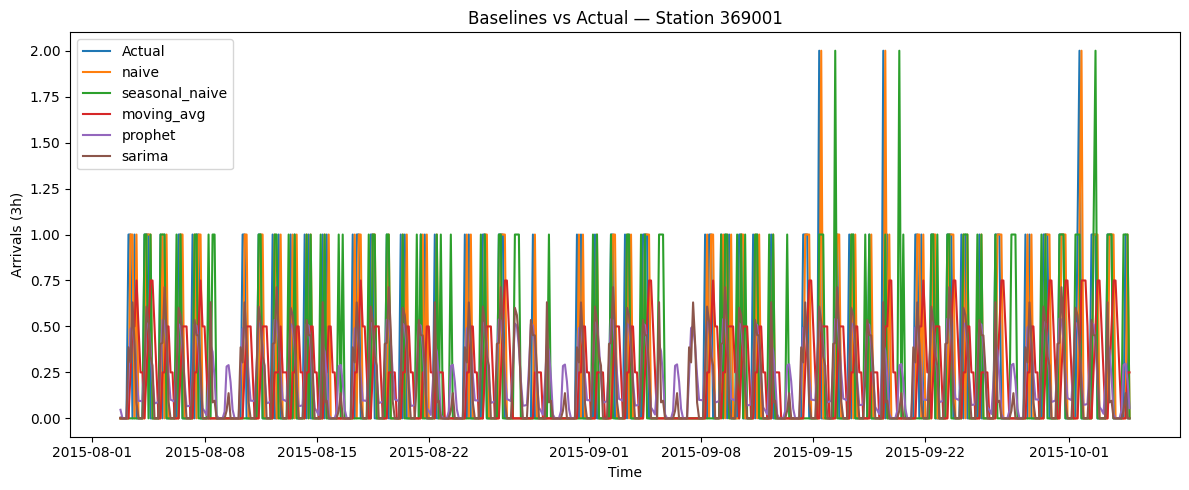

In [25]:
# OPTIONAL: Visualize Prophet & SARIMA vs actual for the busiest station (on val+test)
import matplotlib.pyplot as plt

# pick busiest by total arrivals in history
station_totals = ts_fe.groupby("stationId")["arrivals"].sum().sort_values(ascending=False)
busiest_sid = station_totals.index[0]

gtr = train_df[train_df["stationId"]==busiest_sid].sort_values("timestamp")
gva = val_df  [val_df  ["stationId"]==busiest_sid].sort_values("timestamp")
gte = test_df [test_df ["stationId"]==busiest_sid].sort_values("timestamp")
g_eval = pd.concat([gva,gte])

y_true = g_eval["arrivals"].values.astype(float)

# naive/seasonal/movavg (same as metrics cell)
combined = pd.concat([gtr[["timestamp","arrivals"]], g_eval[["timestamp","arrivals"]]]).reset_index(drop=True)
y_all   = combined["arrivals"].astype(float)
pred_eval = combined.iloc[len(gtr):].copy()
pred_eval["naive"]          = _one_step_naive(y_all).iloc[len(gtr):].values
pred_eval["seasonal_naive"] = _seasonal_naive(y_all, seasonal_lag=BINS_PER_DAY).iloc[len(gtr):].values
pred_eval["moving_avg"]     = _moving_avg(y_all, k=4).iloc[len(gtr):].values

# prophet
try:
    p_out = prophet_fit_predict(gtr[["timestamp","arrivals"]], horizon_bins=len(g_eval), bin_minutes=BIN_MIN)
    pred_eval = pred_eval.merge(p_out, on="timestamp", how="left")
except Exception:
    pred_eval["prophet"] = np.nan

# sarima
try:
    yhat_s = sarima_fit_predict(gtr["arrivals"].astype(float).values, horizon_bins=len(g_eval), s=BINS_PER_WEEK)
    pred_eval["sarima"] = yhat_s
except Exception:
    pred_eval["sarima"] = np.nan

plt.figure(figsize=(12,5))
plt.plot(g_eval["timestamp"], y_true, label="Actual")
for name in ["naive","seasonal_naive","moving_avg","prophet","sarima"]:
    if name in pred_eval:
        plt.plot(g_eval["timestamp"], np.clip(pred_eval[name].values.astype(float),0,None), label=name)
plt.title(f"Baselines vs Actual — Station {busiest_sid}")
plt.xlabel("Time"); plt.ylabel("Arrivals (3h)"); plt.legend(); plt.tight_layout()
plt.show()


### Visualizing Baselines vs Actual (for the busiest station)

**1. Purpose of this plot**
- Numbers in a table don’t always show the full story.  
- This plot helps us **see how different baselines behave compared to actual arrivals** at the busiest station.  
- It shows strengths/weaknesses visually:
  - Do baselines capture spikes?  
  - Do they oversmooth or lag?  
  - Can classical models like SARIMA/Prophet capture seasonality better?  

---

**2. How the plot is built**
- Select the **busiest station** (highest total arrivals).  
- Compute baseline predictions:  
  - `Naive`  
  - `Seasonal Naive`  
  - `Moving Average`  
  - `Prophet` (daily + weekly seasonal model)  
  - `SARIMA` (classical ARIMA with weekly seasonality)  
- Align them with actual arrival counts (3-hour bins).  
- Plot all series together for comparison.  

---

**3. Interpreting the plot**
- **Actual (blue line):** true arrivals at the station.  
- **Naive (orange):** just repeats the previous value → lags behind sudden changes.  
- **Seasonal Naive (green):** repeats the value from the same time last day → captures daily cycles but struggles with unusual days.  
- **Moving Average (red):** smooths past values → misses sharp peaks but shows general trend.  
- **Prophet (purple):** models seasonality → tracks recurring daily/weekly patterns but can be less precise on low-count data.  
- **SARIMA (brown):** strong at modelling autocorrelation and weekly seasonality → often fits cycles and variability better than Prophet.  

---

**4. Insights from this visualization**
- **Seasonal Naive** is a surprisingly strong simple baseline (daily cycles).  
- **Prophet** captures seasonal trends but can drift on sparse arrival data.  
- **SARIMA** provides smoother and more accurate absolute forecasts compared to other baselines.  
- **Naive** and **Moving Average** are weakest — too simple to capture spikes.  
- The **actual series** is spiky and low-count, highlighting the challenge of forecasting.  

---

✅ **In short:**  
- Adding **Prophet** and **SARIMA** shows the difference between **simple rules** and **classical time-series models**.  
- While **SARIMA and Seasonal Naive** capture daily/weekly cycles well, they still miss irregular spikes.  
- This motivates the need for **Poisson-LSTM**, which is better at learning patterns in sparse, spiky data and integrates directly with **queueing theory** for congestion modelling.  
